# Project setup

Import necessary libraries

In [74]:
# System
import os
import shutil
import glob

# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# CNN
from keras.utils import to_categorical, set_random_seed
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

# Machine Learning
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [75]:
SEED = 42
random.seed(SEED)
set_random_seed(SEED)
np.random.seed(SEED)

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [76]:
INIT_DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

INIT_TRAIN_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Train/Train/')
INIT_TEST_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Test/Test/')

DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [77]:
image_classes = os.listdir(INIT_TRAIN_DIR)

if image_classes == os.listdir(INIT_TEST_DIR):
    print('The same classes are in each folder')
else:
    print('The two folders contain different classes')

The same classes are in each folder


In [78]:
# # image_classes = ['零', '一', '二']
# # image_classes = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十']
# # image_classes = image_classes_train[:20]
# image_classes = random.sample(image_classes, 50)
# # image_classes = image_classes_train

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [79]:
# Remove old data
if os.path.exists(DIR):
    shutil.rmtree(DIR)
    
#Create the new directory
os.mkdir(DIR)
for image_class in image_classes:
    path = os.path.join(DIR, image_class)
    os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DIR` variable.

In [80]:
def combineDirectories():
    for image_class in image_classes:
        images = []

        # Fetch images from train dir
        train_path = os.path.join(INIT_TRAIN_DIR, image_class)
        images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

        # Fetch images from test dir
        test_path = os.path.join(INIT_TEST_DIR, image_class)
        images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

        # Iterate over the splits and images and copy them to the data directory
        for i, image in enumerate(images):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(DIR, image_class, new_filename)
            shutil.copy(image, destination_path)
            
combineDirectories()

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [81]:
def checkGrayscale():
    # Loop through each subdirectory and file in the directory
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            if image.lower().endswith('.png'):
                file_path = os.path.join(subdir, image)

                with Image.open(file_path) as img:
                    if img.mode != 'L':
                        print(f"{file_path} is not grayscale.")
            else:
                print("Not a png file: ")
checkGrayscale()

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [82]:
def checkAspectRatios():
    image_sizes = []

    # Iterate through all the images and check if any do not have a 1:1 aspect ratio
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                image_sizes.append(img.size[0])

                if img.size[0] != img.size[1]:
                    print(file_path, img.size)
                    
    return image_sizes
                    
image_sizes = checkAspectRatios()

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


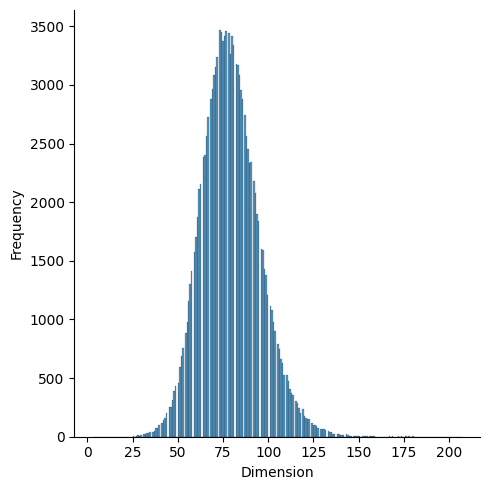

In [83]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will enforce a minimum image size.

In [84]:
MIN_IMAGE_SIZE = 20
IMAGE_SIZE = 48

def resizeImages():
    # Iterate through all the images and resize to a fixed size
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                current_size = img.size[0]
                if current_size < MIN_IMAGE_SIZE:
                    os.remove(file_path)
                    continue
                
                if current_size != IMAGE_SIZE:
                    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
                
                img = ImageOps.invert(img)
                img.save(file_path)
                
resizeImages()

Now lets check how many images we have in each class and see how balanced the classes are.

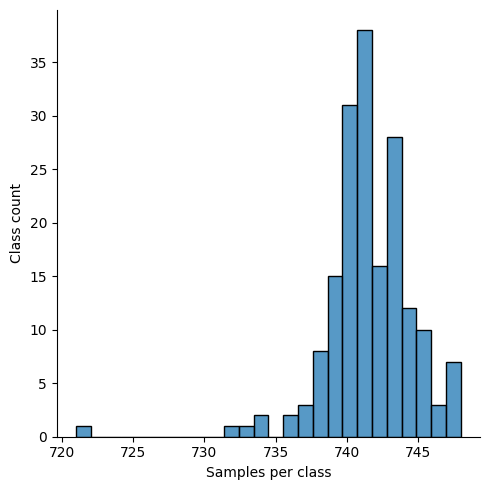

            Count
count  178.000000
mean   741.269663
std      3.031898
min    721.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


In [ ]:
def get_class_counts():
    class_counts = {}
    
    for subdir in glob.glob(os.path.join(DIR, '*')):
        file_count = len(glob.glob(os.path.join(subdir, '*')))
        class_counts[subdir.split('/')[-1]] = file_count

    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

df_class_counts = get_class_counts() 

sns.displot(list(df_class_counts['Count']))
plt.xlabel('Samples per class')
plt.ylabel('Class count')
plt.tight_layout()
plt.show()

print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [ ]:
df_class_counts = get_class_counts() 

mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

   Count
月    748
零    732
六    733
老    734
四    734
样    721


As we can see, the imbalance is minimal. Because of this, we will not be using any class balancing techniques.

Let's have a look some examples of the images in the dataset.

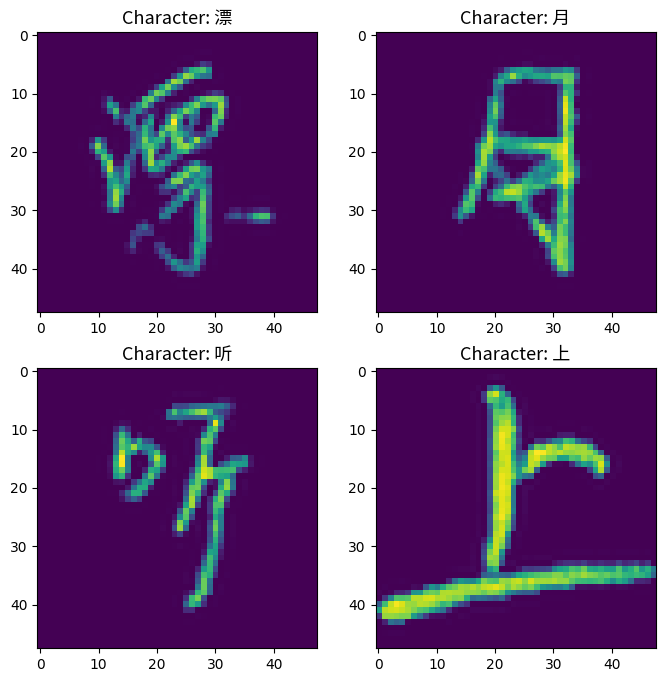

In [ ]:
import glob

# Get list of all .png images in the directory and its subdirectories
images = glob.glob(os.path.join(DIR, '**', '*.png'), recursive=True)

# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for i in range(2):
    for j in range(2):
        img_path = random_images[2 * i + j]
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"Character: {img_path.split('/')[1]}", fontproperties=prop,fontsize = 13)

# NumPy Array Conversion

Now we can convert all the images into one single numpy array with the corresponding labels for each image.

In [ ]:
def get_numpy_data(classes):
    images = []
    labels = []
    for image_class in classes:
        path = os.path.join(DIR, image_class)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)

            img = Image.open(image_path)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(image_class)
            
    return np.array(images), np.array(labels)

Now we can convert the python lists into numpy arrays.

In [ ]:
# random_image_classes = random.sample(image_classes, 50)

images, labels = get_numpy_data(image_classes)

And finally we can save the numpy arrays to the root directory.

In [ ]:
np.save('images.npy', images)
np.save('labels.npy', labels)

## CNN Training

In [40]:
images = np.load('images.npy').astype("float32") / 255
labels = np.load('labels.npy')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def one_hot_encode_labels(y1, y2):
    print(y1)
    print(y2)
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate((y1, y2)))
    
    y1_encoded = label_encoder.transform(y1)
    y2_encoded = label_encoder.transform(y2)
    
    num_classes = len(label_encoder.classes_)
    y1_categorical = to_categorical(y1_encoded, num_classes=num_classes)
    y2_categorical = to_categorical(y2_encoded, num_classes=num_classes)
    
    return y1_categorical, y2_categorical

y_train_ohe, y_test_ohe = one_hot_encode_labels(y_train, y_test)

NUM_CLASSES = y_train_ohe.shape[1]

['爱' '话' '猫' ... '喜' '关' '下']
['杯' '住' '店' ... '听' '少' '下']


In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)
print(y_train.shape)
print(y_test.shape)

(29654, 48, 48)
(7414, 48, 48)
(29654, 50)
(7414, 50)
(29654,)
(7414,)


In [42]:
def getCNNModel(hp):
    model = Sequential([
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
        
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)),
        
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.7, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [44]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=15,
    directory='hyperband',
    project_name='cnn_tuning5')

EPOCHS = 30

annealer = LearningRateScheduler(
    lambda x: 1e-3 * 0.99 ** (2 * x))
stop_early = EarlyStopping(
    monitor='loss',
    patience=5)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True)

tuner.search(
    X_train, y_train_ohe,
    validation_split=0.2,
    callbacks=[annealer, stop_early, checkpoint],
    epochs=EPOCHS, batch_size=128)

Trial 30 Complete [00h 03m 41s]
val_accuracy: 0.9603776931762695

Best val_accuracy So Far: 0.9603776931762695
Total elapsed time: 00h 27m 35s


In [45]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 24, 'dropout_1': 0.4, 'conv_2_filters': 64, 'dropout_2': 0.1, 'conv_3_filters': 128, 'dropout_3': 0.2, 'dense_units': 512, 'dropout_4': 0.6000000000000001, 'learning_rate': 0.0005, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_history = []

for i, (train_idxs, val_idxs) in enumerate(kfold.split(X_train, y_train_ohe)):
    print(f"Fold {i + 1}/{k}")
    
    model = load_model('best_model.h5')
    
    history = model.fit(
        X_train[train_idxs],
        y_train_ohe[train_idxs],
        validation_data=(X_train[val_idxs], y_train_ohe[val_idxs]),
        epochs=15,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)

Fold 1/3
Epoch 1/15
309/309 [==============================] - 11s 36ms/step - loss: 0.3125 - accuracy: 0.9050 - val_loss: 0.0955 - val_accuracy: 0.9707
Epoch 2/15
309/309 [==============================] - 11s 35ms/step - loss: 0.2967 - accuracy: 0.9077 - val_loss: 0.1246 - val_accuracy: 0.9604
Epoch 3/15
309/309 [==============================] - 11s 34ms/step - loss: 0.2753 - accuracy: 0.9145 - val_loss: 0.1153 - val_accuracy: 0.9655
Epoch 4/15
309/309 [==============================] - 11s 34ms/step - loss: 0.2601 - accuracy: 0.9189 - val_loss: 0.0999 - val_accuracy: 0.9703
Epoch 5/15
309/309 [==============================] - 11s 35ms/step - loss: 0.2398 - accuracy: 0.9252 - val_loss: 0.1191 - val_accuracy: 0.9658
Epoch 6/15
309/309 [==============================] - 11s 36ms/step - loss: 0.2291 - accuracy: 0.9282 - val_loss: 0.1046 - val_accuracy: 0.9683
Epoch 7/15
309/309 [==============================] - 11s 37ms/step - loss: 0.2184 - accuracy: 0.9309 - val_loss: 0.1127 - val_

In [46]:
full_model = load_model('best_model.h5')
feature_model = Model(inputs=full_model.input, outputs=full_model.layers[-4].output)

train_features = feature_model.predict(X_train)
test_features = feature_model.predict(X_test)

232/232 [==============================] - 2s 7ms/step


In [47]:
print(train_features.shape)

(29654, 2048)


In [48]:
logistic_regressor = LogisticRegression(solver='saga', max_iter=200, verbose=1, n_jobs=-1)
logistic_regressor.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.17716336
Epoch 3, change: 0.09755169
Epoch 4, change: 0.06104966
Epoch 5, change: 0.05853594
Epoch 6, change: 0.04133116
Epoch 7, change: 0.03790245
Epoch 8, change: 0.03314668
Epoch 9, change: 0.03180011
Epoch 10, change: 0.02818997
Epoch 11, change: 0.02520837
Epoch 12, change: 0.02467807
Epoch 13, change: 0.02093246
Epoch 14, change: 0.01914958
Epoch 15, change: 0.01804885
Epoch 16, change: 0.01655844
Epoch 17, change: 0.01672209
Epoch 18, change: 0.01592217
Epoch 19, change: 0.01347378
Epoch 20, change: 0.01311072
Epoch 21, change: 0.01150175
Epoch 22, change: 0.01192667
Epoch 23, change: 0.01114256
Epoch 24, change: 0.01136521
Epoch 25, change: 0.01031033
Epoch 26, change: 0.00913385
Epoch 27, change: 0.00886872
Epoch 28, change: 0.00898746
Epoch 29, change: 0.00875986
Epoch 30, change: 0.00724233
Epoch 31, change: 0.00684575
Epoch 32, change: 0.00677380
Epoch 33, change: 0.00676094
Epoch 34, change: 0.00695038
Epoch 35, change: 0.006

/home/miikey_lol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, solver='saga', verbose=1)

In [49]:
log_predictions = logistic_regressor.predict(test_features)

In [50]:
report = classification_report(y_test, log_predictions, digits=4)
print(report)

              precision    recall  f1-score   support

           七     0.9524    0.9722    0.9622       144
           上     0.9926    0.9710    0.9817       138
           下     0.9857    1.0000    0.9928       138
           东     0.9655    0.9211    0.9428       152
           买     0.9793    0.9793    0.9793       145
           五     1.0000    0.9660    0.9827       147
           什     0.9787    0.9583    0.9684       144
           们     0.9664    1.0000    0.9829       144
           会     0.9630    0.9701    0.9665       134
           住     0.9866    0.9608    0.9735       153
           作     0.9748    0.9873    0.9810       157
           候     0.9925    0.9708    0.9815       137
           关     0.9647    0.9762    0.9704       168
           兴     0.9804    0.9868    0.9836       152
           写     0.9793    0.9726    0.9759       146
           几     1.0000    0.9739    0.9868       153
           分     0.9808    0.9745    0.9776       157
           医     0.9763    

In [51]:
f1s = []
accuracys = []

for i in range(2, 50, 1):
    # Create an instance of the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean", n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(train_features, y_train)
    
    # Predict the labels for the test data
    knn_predictions = knn.predict(test_features)
    
    # Calculate the accuracy score
    accuracys.append(accuracy_score(y_test, knn_predictions))

    # Calculate the f1 score
    f1s.append(f1_score(y_test, knn_predictions, average='weighted'))
    
    print(f"k={i}, {accuracys[-1]}, {f1s[-1]}")

k=1, 0.9320205017534394, 0.9320333354094308
k=2, 0.9236579444294578, 0.9234632584499409
k=3, 0.935122740760723, 0.9351316464696292
k=4, 0.9379552198543296, 0.9379921787315746
k=5, 0.9418667386026437, 0.9418664827145421
k=6, 0.9420016185594821, 0.9419797708728109
k=7, 0.9449689776099272, 0.944980302010864
k=8, 0.944564337739412, 0.9445852375353653
k=9, 0.9460480172646345, 0.9460632726371521
k=10, 0.9449689776099272, 0.9449182268599144
k=11, 0.945238737523604, 0.9452125213927784
k=12, 0.9444294577825735, 0.9444943373566006
k=13, 0.944564337739412, 0.9445727246255672
k=14, 0.9455084974372808, 0.9455981935197081
k=15, 0.9440248179120583, 0.9441535840737111
k=16, 0.9433504181278662, 0.9434629349712335
k=17, 0.9430806582141894, 0.9432009298520947
k=18, 0.9411923388184515, 0.9412905355754615
k=19, 0.9407876989479363, 0.9408822468770961
k=20, 0.9403830590774211, 0.94049896850531
k=21, 0.9405179390342595, 0.9405900845613012
k=22, 0.9409225789047747, 0.9410031234319305
k=23, 0.9411923388184515, 

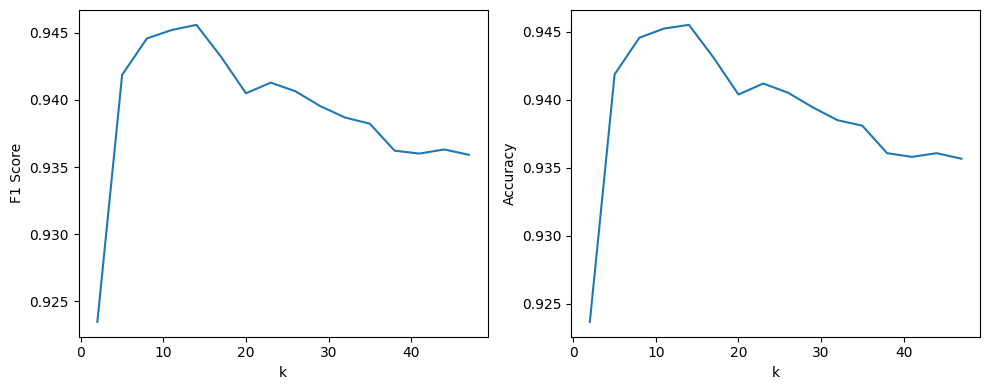

In [72]:
STEP = 3
k_values = range(2, 50, STEP)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(k_values, f1s[::STEP])
ax1.set_xlabel('k')
ax1.set_ylabel('F1 Score')

ax2.plot(k_values, accuracys[::STEP])
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=750, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   44.0s finished


RandomForestClassifier(n_estimators=750, n_jobs=-1, random_state=42, verbose=1)

In [11]:
rf_score = rf.score(test_features, y_test)
print(f"Random Forest Accuracy: {rf_score}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s


Random Forest Accuracy: 0.9402481791205827


[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed:    0.9s finished


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, verbose=1)

# Fit the classifier to the training data using grid search
grid_search.fit(train_features, y_train)

In [73]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

NameError: name 'best_params' is not defined

In [ ]:
# Predict the labels for the test data using the best estimator
svm_predictions = grid_search.best_estimator_.predict(test_features)

In [30]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, svm_predictions)

# Calculate the f1 score
f1 = f1_score(y_test, svm_predictions, average='weighted')

# Print the accuracy and f1 score report
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.9718100890207715
F1 Score: 0.9718150695213609
